In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from matplotlib import colors
from xhistogram.xarray import histogram
import util

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

chunks = {"x":2000, "ncol":2000}

In [2]:
run = "dpscream_rce_large_3km_aa_default"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
file = run_dir + f"{run}_h0_last5days"
qsmall=1e-8

In [3]:
plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other

# plot one run micro-hist

In [4]:
####################################################################
# plot 1 run
####################################################################

file = run_dir + f"{run}_h0_last5days.nc"
print(file)
ds = xr.open_dataset(file, chunks=chunks)[["T","CLDICE","NUMICE","Q"]]  # .isel(time=slice(-20,-1))
# bcu = xr.open_dataset(run_dir+f"{run}_BCU_hrs.nc", chunks=chunks)['BCU'].sel(time=ds.time, method="nearest")
# nuc = xr.open_dataset(run_dir+f"{run}_NUC_hrs.nc", chunks=chunks)['NUC'].sel(time=ds.time, method="nearest")
print("getting t<-60 and cldice>qsmall...")
ds = ds.where((ds["T"]<213.15)&(ds.CLDICE>qsmall))
# nuc = nuc.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
# ds = ds.where((nuc==0))  # &(bcu<50))  # .compute()
print(ds.Q.shape)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/dpscream_rce_large_3km_aa_default/run/dpscream_rce_large_3km_aa_default_h0_last5days.nc
getting t<-60 and cldice>qsmall...
(20, 128, 147456)


In [5]:
print("calc Rice...")
# x_array = np.cbrt(3*ds.CLDICE/(4*np.pi*920.0*ds.NUMICE))
# x_array = x_array * 1e6
x_array = util.calc_rice(ds.CLDICE, ds.NUMICE)
print(x_array.shape)


calc Rice...
(20, 128, 147456)


[########################################] | 100% Completed | 212.05 s


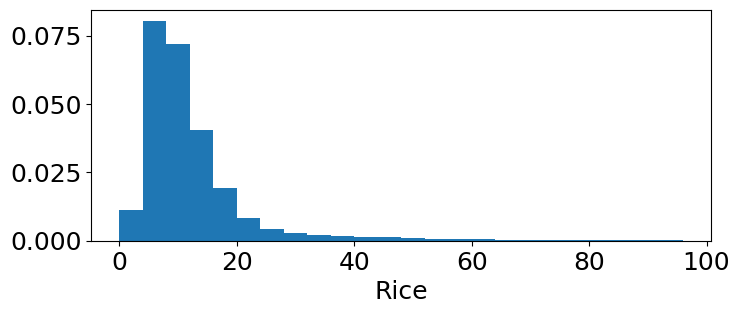

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
x_array.plot.hist(bins=np.arange(0,100,4), ax=ax, density=1)
# ax.axis('off')
ax.set(xlabel="Rice")
plt.savefig(f"../plots/large/hist_calc_rice_{run}.png", dpi=120)
plt.show()

In [5]:
print("calc NI...")
y_array = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
print(y_array.shape)

calc NI...
(20, 128, 147456)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
y_array.plot.hist(bins=np.logspace(-4,1,50), ax=ax, density=1)
ax.set(xscale="log",
       xlabel="Ni")
plt.savefig(f"../plots/large/hist_calc_ni_{run}.png", dpi=120)
plt.show()

[#######                                 ] | 17% Completed | 69.68 ss

In [9]:
# print("flattening...")
# x_array = x_array.values.flatten()
# print("x done...")

# n = len(x_array)
# y_array = y_array.values.flatten()/1e6  # convert to cm-3
# print("y done...")
# # z_array = nuc.values.flatten()
# print(x_array.shape, y_array.shape)  # , z_array.shape)
# x_array = x_array[~np.isnan(y_array)]
# y_array = y_array[~np.isnan(y_array)]
# # z_array = z_array[~np.isnan(z_array)]
# print(x_array.shape, y_array.shape, n)  # , z_array.shape, n)

In [10]:
# xbins=np.linspace(0,100,100)
# ybins=np.logspace(-5,2,70)
# stat='count'

# hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None,
#                                                   statistic=stat, bins=[xbins,ybins])
# hist = np.where(hist>0,hist,np.nan)
# hist = hist/n
# print(np.nansum(hist),stat,end="")

# xbins = (xbins[1:]+xbins[:-1])/2
# ybins = (ybins[1:]+ybins[:-1])/2

In [11]:
xbins=np.linspace(0,100,100)
ybins=np.logspace(-5,2,70)
stat='count'

In [12]:
x_array = xr.DataArray(x_array, dims=x_array.dims, name="Rice")
y_array = xr.DataArray(y_array, dims=y_array.dims, name="ICNC")

In [13]:
x_array

<xarray.DataArray 'Rice' (time: 20, lev: 128, x: 147456)>
dask.array<mul, shape=(20, 128, 147456), dtype=float32, chunksize=(20, 128, 2000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-02-15 06:00:00 ... 2000-02-20 00:00:00
  * lev      (lev) float64 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
Dimensions without coordinates: x

[########################################] | 100% Completed | 277.90 s
[########################################] | 100% Completed | 278.00 s


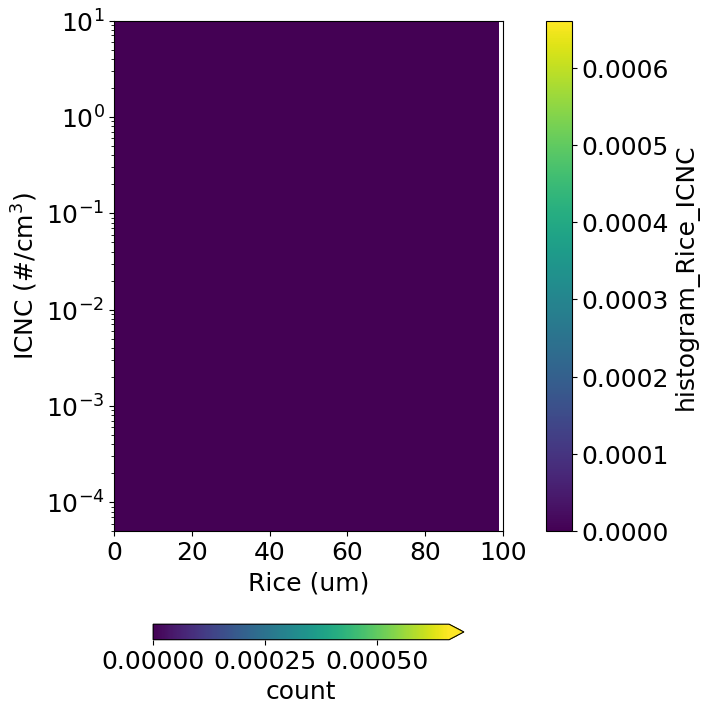

In [14]:
print("plotting... ", end="")
fig, ax = plt.subplots(1, 1, figsize=(7,7), constrained_layout=True)
weights = xr.ones_like(x_array) / np.prod(x_array.shape) * 100
cf = histogram(x_array, y_array, bins=[xbins,ybins], weights=weights, dim=['time','lev','x']).plot.pcolormesh(ax=ax)
# cf = ax.pcolormesh(xbins, ybins, (hist*100).T, cmap="plasma_r",
#                       shading='auto',
#                       # levels=[0,1,2,4,8,16,32,48]
#                       vmin = 0, vmax=0.05 #0.02, 0.3 std
#                      )
ax.set(yscale='log')
ax.set(xlim=[0,100], ylim=[5e-5,10])
ax.set(ylabel="ICNC (#/cm$^3$)", xlabel="Rice (um)")
plt.colorbar(cf, ax=ax, label=f"{stat}", location="bottom", shrink=0.8, extend='max')
plt.savefig("../plots/large/micro_hist_run_{}_{}.png".format(run.split("_")[-1], stat), dpi=120)
plt.show()

# plot two runs - micro-hist

0... 11991404 total...11845104.0 counts...plotting... done
1... 3713629 total...3645499.0 counts...plotting... done
2... plotting... done


FileNotFoundError: [Errno 2] No such file or directory: 'plots/micro_hist_run_RICE-NI_f_default-i_bgicenuc-diff.png'

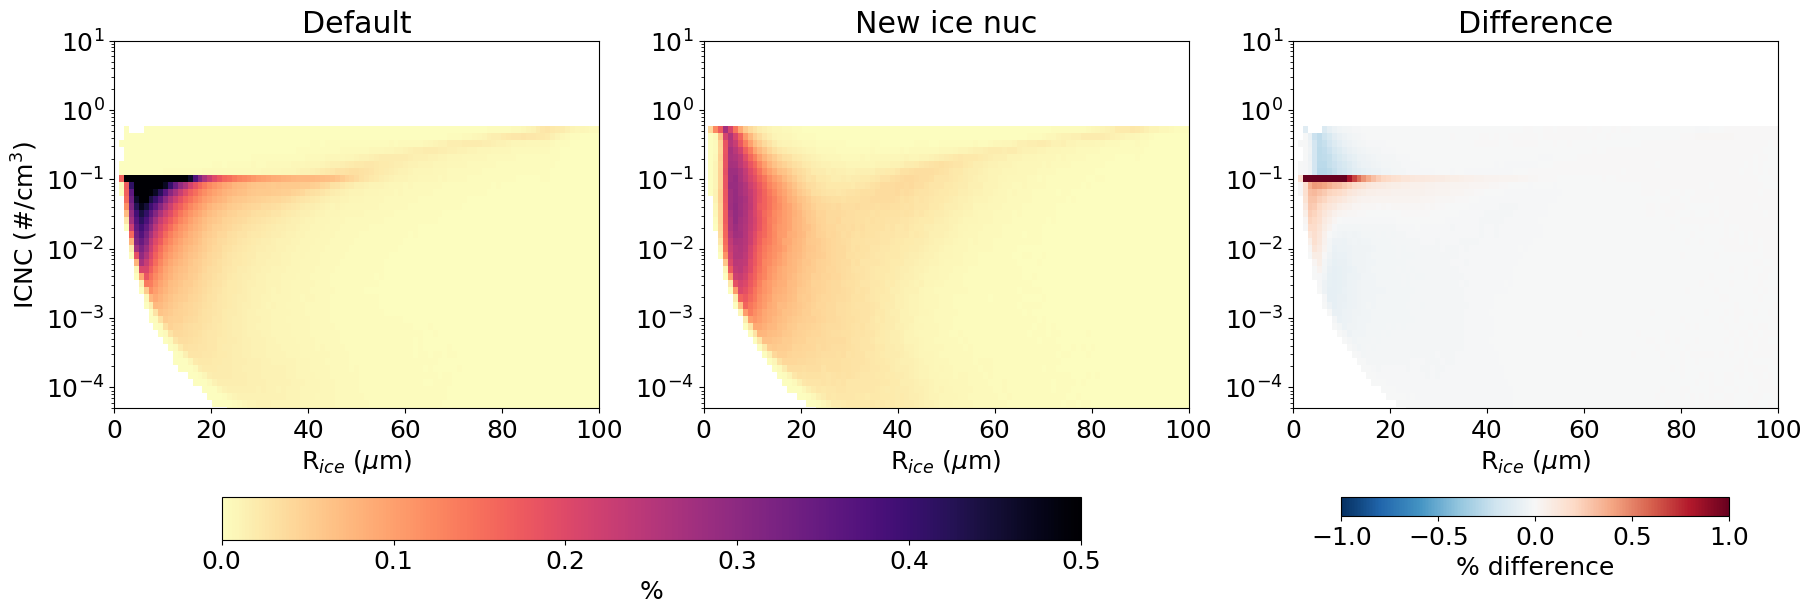

In [10]:
####################################################################
# difference plot between two runs                                 #
####################################################################

var_names = ["RICE","NI"]
hists = [None, None]
qsmall=1e-8 #kg/kg
run_names.append("Difference")

plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
for i in range(len(runs)+1):
    print(i, end="... ")
    if i<2:
        file = run_dir + "scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
        ds = xr.open_dataset(file)
        if var_names[0]=="RICE":
            x_array = calc_rice(ds.CLDICE, ds.NUMICE).flatten()
        else:
            x_array = ds[var_names[0]].values.flatten()
        if var_names[1]=="NI":
            y_array = calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
            y_array = y_array.where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
        else: 
            y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 #. # convert to cm-3
        x_array = x_array[~np.isnan(y_array)]
        y_array = y_array[~np.isnan(y_array)]
        n = len(x_array)
        print(n,"total", end="...")
    xbins=np.linspace(0,100,100)
    ybins=np.logspace(-5,2,70)

    if i<2:
        hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                      statistic="count", bins=[xbins,ybins])
        hist = np.where(hist>0,hist,np.nan)
        print(np.nansum(hist),"counts...",end="")
    xbins = (xbins[1:]+xbins[:-1])/2
    ybins = (ybins[1:]+ybins[:-1])/2
    print("plotting... ", end="")
    if i<2:
        hists[i] = hist/n
        cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                              shading='auto',
                              vmin = 0, vmax=0.5 #0.02, 0.3 std
                             )
    else:
        cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                              shading='auto',
                              cmap="RdBu_r",
                               norm=colors.Normalize(vmin=-1, vmax=1) #0.02, 0.3 std
                             )
    ax[i].set(yscale="log", xlabel="R$_{ice}$ ($\mu$m)", title=run_names[i], xlim=[0,100],ylim=[5e-5,10])
    print("done")
ax[0].set_ylabel("ICNC (#/cm$^3$)")
fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
plt.savefig("../plots/small/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
run_names[:2]
plt.show()
##############################################################
##############################################################

In [ ]:

run_names

In [23]:
if plt_2drhice:
    var_names = ["RHICE","NI"]
    fig, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True)
    x_array = ds[var_names[0]].where(ds["T"]<233.15).values.flatten()
    y_array = ds[var_names[1]].where(ds["T"]<233.15).where(ds.CLDICE>qsmall).values.flatten()/1e6 # convert to cm-3
    x_array = x_array[~np.isnan(y_array)]
    y_array = y_array[~np.isnan(y_array)]
    xbins=np.linspace(np.min(x_array),np.max(x_array),50)
    ybins=np.logspace(-5,1,50)
    n = len(x_array)

    hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                      statistic="count", bins=[xbins,ybins])
    xbins = (xbins[1:]+xbins[:-1])/2
    ybins = (ybins[1:]+ybins[:-1])/2
    cf = ax.pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                       shading="auto", vmax=0.4
                        # locator=ticker.LogLocator(), 
                        # levels=np.logspace(0,6,7)
                    )
    ax.set_yscale("log")
    ax.set_xlabel("RH wrt ice (percent)")
    ax.set_ylabel(ds[var_names[1]].long_name+" (c"+ds[var_names[1]].units+")")
    ax.grid(True)
    ax.set_axisbelow(True)
    fig.colorbar(cf, ax=ax, label="%", location="right", shrink=1)    
    ax.set_title("RUN "+run.upper()+" where T$<-40^\circ$C and $qi>{}$".format(qsmall))
    ax.set_xlim([50,150])
    ax.set_ylim([5e-5,10])
    plt.savefig("plots/micro_hist_run_{}-{}_{}.png".format(var_names[0],var_names[1], run), dpi=120)
    plt.show()

In [22]:
####################################################################
# difference plot between two runs                                 #
####################################################################

if plt_2drhice:
    runs = ['ck','ch']
    run_names = ['Standard', 'New Freezing', 'Difference']
    var_names = ["T","RHI"]
    hists = [None, None]
    qsmall=1e-8 #kg/kg
    xbins=np.linspace(180,250,30)
    ybins=np.linspace(0,251,60)

    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
    for i in range(len(run_names)):
        print(i, end="... ")
        if i<2:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            x_array = ds[var_names[0]].values.flatten()
            if var_names[1]=="RHI":
                y_array = calc_rhice(ds).values.flatten()
            else:
                y_array = ds[var_names[1]].where(ds.CLDICE>qsmall).values.flatten()
            x_array = x_array[~np.isnan(y_array)]
            y_array = y_array[~np.isnan(y_array)]
            n = len(x_array)
            print(n,"total", end="...")

        if i<2:
            hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
            hist = np.where(hist>0,hist,np.nan)
            print(np.nansum(hist),"counts...",end="")
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        print("plotting... ", end="")
        if i<2:
            hists[i] = hist/n
            cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                                  shading='auto',
                                  vmin = 0, vmax=0.5 #0.02, 0.3 std
                                 )
        else:
            cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                                  shading='auto',
                                  cmap="RdBu_r",
                                   norm=colors.Normalize(vmin=-0.5, vmax=0.5) #0.02, 0.3 std
                                 )
        print("done")
        ax[i].set(xlabel="Temperature (K)", title=run_names[i], xlim=[180,250], ylim=[40,160])
    ax[0].set(ylabel="RH$_{i}$ (%)")
    fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
    fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
    plt.savefig("plots/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
    plt.show()
    ##############################################################
    ##############################################################


In [21]:
####################################################################
# difference plot between two runs                                 #
####################################################################

if plt_2drhice:
    runs = ['ck','ch']
    run_names = ['Standard', 'New Freezing', 'Difference']
    var_names = ["RHI","NI"]
    hists = [None, None]
    qsmall=1e-8 #kg/kg
    xbins=np.linspace(180,250,30)
    ybins=np.linspace(0,250,60)

    plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other
    fig, ax = plt.subplots(1, 3, figsize=(18,6), constrained_layout=True)
    for i in range(len(run_names)):
        print(i, end="... ")
        if i<2:
            file = run_dir + "scream_dp_RCE_SMALL_3km_"+runs[i]+\
                    "/run/scream_dp_RCE_SMALL_3km_{}.eam.h0.2000-01-01-00000.nc".format(runs[i])
            ds = xr.open_dataset(file)
            if var_names[0]=="RHI":
                x_array = calc_rhice(ds).values.flatten()
            else:
                x_array = ds[var_names[0]].where(ds.CLDICE>qsmall).values.flatten()
            if var_names[1]=="NI":
                y_array = calc_rhice(ds).values.flatten()/1e6
            else:
                y_array = ds[var_names[1]].where(ds.CLDICE>qsmall).values.flatten()        
            x_array = x_array[~np.isnan(y_array)]
            y_array = y_array[~np.isnan(y_array)]
            n = len(x_array)
            print(n,"total", end="...")

        if i<2:
            hist, xbins, ybins, _ = stats.binned_statistic_2d(x_array, y_array, None, 
                                                          statistic="count", bins=[xbins,ybins])
            hist = np.where(hist>0,hist,np.nan)
            print(np.nansum(hist),"counts...",end="")
        xbins = (xbins[1:]+xbins[:-1])/2
        ybins = (ybins[1:]+ybins[:-1])/2
        print("plotting... ", end="")
        if i<2:
            hists[i] = hist/n
            cf = ax[i].pcolormesh(xbins, ybins, (hist/n*100).T, cmap="magma_r", 
                                  shading='auto',
                                  vmin = 0, vmax=0.5 #0.02, 0.3 std
                                 )
        else:
            cfd = ax[i].pcolormesh(xbins, ybins, ((hists[0]-hists[1])*100).T,  
                                  shading='auto',
                                  cmap="RdBu_r",
                                   norm=colors.Normalize(vmin=-0.5, vmax=0.5) #0.02, 0.3 std
                                 )
        print("done")
        ax[i].set(xlabel="RHi (%)", title=run_names[i], xlim=[180,250], ylim=[40,160])
    ax[0].set(ylabel="ICNC (cm$^-3$)")
    fig.colorbar(cf, ax=ax[:2], label="%", location="bottom", shrink=0.8)
    fig.colorbar(cfd, ax=ax[2], label="% difference", location="bottom", shrink=0.8)
    plt.savefig("plots/micro_hist_run_{}-{}_{}-{}-diff.png".format(var_names[0],var_names[1],runs[0],runs[1]), dpi=120)
    plt.show()
    ##############################################################
    ##############################################################


In [ ]:
##############################################
# ICNC vs w
##############################################

if plt_icncvsw:
    ds = xr.open_dataset(file)
    print()
    w = omega2w(ds.OMEGA, ds.Q, ds.lev, ds.T)